# Quality of the data in general


Here I plot graphs of peak I and FWHM variations for different cycles.
All data were reduced using the SPHERE DC without normalisation (which is useful for this case and will be performed later)
Apperture polarimetry

Works for all ZIMPOL data reduced with individual cycles
Specifically for the AR Pup


__This script is in use for paper Andrych et al 2024b__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter,EngFormatter


In [3]:
def load_and_make_polar(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            i=(iq+iu)/2
            q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
            q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-10
            u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
    return iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi

def load_and_make_polar_umon(dirdat,cycle,camera):
    #q
    dir = dirdat+'q_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            q = hdulq[0].data
            n=q.shape[0]
    #u
    dir = dirdat+'u_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            u = hdulq[0].data
    #qphi
    dir = dirdat+'qphi_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            qphi = hdulq[0].data
            
    #uphi
    dir = dirdat+'uphi_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            uphi = hdulq[0].data
            
            
            
    #iq,iu
    dir = dirdat+'sci/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            iu = hdulq[0].data[2]
            
            
            
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            
            i=(iq+iu)/2
            
            # qphi = (qphi > 0)*qphi +  (qphi <=0 )*1e-10
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
            
    return iq,q,iu,u,i,qphi,uphi,pi,aolp,R,phi

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   

def maskcrit(aolp,R):
    phi = (aolp-90)  
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>180:
                phi[ix,iy]=phi[ix,iy]-180
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmedian(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,R,Q,U,I,Q_PHI,PI,AOLP,title,save):
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = I.shape[0]
    d = n * ps / 2

    im1=i_plot.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical')

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = i_plot.get_xlim()
    yy0, yy1 = i_plot.get_ylim()

    # binning factor
    factor = [4, 4]

    # re-binned number of points in each axis
    nx_new = PI.shape[1] // factor[0]
    ny_new = PI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    PI_bin=PI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    aolp_bin=AOLP.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

    # polarization angle
    psi=0.5*np.arctan2(U_bin, Q_bin)

    #psi=aolp_bin
    #i_plot.imshow(psi, origin='lower',extent=(-d, d, d, -d))

    # polarization fraction
    frac =Q_phi_bin/I_bin
    #frac=dolp_v[adc:bdc,adc:bdc]
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=10
    mask=mask2#*mask1
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)
    plt.title(title)
    plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    #plt.show()#(dirName+"aolp.png",bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.png',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2*ps

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

In [7]:
#star='IRAS08544-4431'  'HD83878'   'HD75885' 'AR_Pup'

#stars=['HR4049_20190108','HR4049_20190107','HR4226','HD71253','HD94680','HD96314','HD98025','V709_Car','HD75885', 'AR_Pup_dc_notnorm','UMon']
stars=['02.SCI_AR_Pup']
# stars=['REF_HD75885']
starnames = {'02.SCI_AR_Pup':'AR_Pup','UMon':'UMon','AR_Pup_dc_notnorm':'AR_Pup','UMon_Katya':'UMon_Katya','REF_HD75885':'HD75885'}
fittypes=['1', '2']

band=['V','I']
ps=3.6


## Apperture polarimetry and other characteristics for each frame in the sample

### In the following cell: without correction of the intrinsic polarisation

max DoLP in the region R>=1.5 and R<500/ps  (500 mas in radius)

HERE IS NOT THE FINAL VERSION THAT WENT TO THE PAPER. FOR THE PAPER IN "Paper2_IRAS08_with_ref_correction.ipynb" FOR THE SELECTED FRAMES

In [6]:

for star in stars:
    # create folders for data and image outputs
    figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/'
    createfolder(figfolder)
    figfolder0=figfolder+ 'Quality_indiv_cycles/'
    createfolder(figfolder)
    figfolder=figfolder+ 'no_unres_correction/'
    createfolder(figfolder)
    
    if star=='01.SCI_AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
        input_filename =dirdat+'process_list.csv'
    elif star=='01.SCI_AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star] +'/' #For AR_Pup
        input_filename =dirdat+'process_list.csv'

  
        
    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}


    print(reference)

    for fittype in fittypes:
        #output_filename = dirdat+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
        output_filename = figfolder0+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
        with open(output_filename, 'w') as file_print:
            line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                'reference','cycle',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]",
                'FWHM','CNT60[%]','Peak_i(Strehl)','Peak_PI','peak_Q_Phi',
                '0-3_PSF', '0-3_Q', '0-3_U', '0-3_Q/I[%]', '0-3_U/I[%]',
                '0-5_PSF', '0-5_Q', '0-5_U', '0-5_Q/I[%]', '0-5_U/I[%]',
                '0-10_PSF', '0-10_Q', '0-10_U', '0-10_Q/I[%]', '0-10_U/I[%]',
                '0-50_PSF', '0-50_Q', '0-50_U', '0-50_Q/I[%]', '0-50_U/I[%]',
                '0-100_PSF', '0-100_Q', '0-100_U', '0-100_Q/I[%]', '0-100_U/I[%]',
                '1-3_PSF', '1-3_Q', '1-3_U', '1-3_Q/I[%]', '1-3_U/I[%]',
                '3-5_PSF', '3-5_Q', '3-5_U', '3-5_Q/I[%]', '3-5_U/I[%]',
                '3-30_PSF', '3-30_Q', '3-30_U', '3-30_Q/I[%]', '3-30_U/I[%]',
                '5-30_PSF', '5-30_Q', '5-30_U', '5-30_Q/I[%]', '5-30_U/I[%]')

            file_print.write(line)
          
            for process in processes:
                
                print(process)
                
                if star=='UMon':
                    dirName=dirdat
                    iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                else:        
                    dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                    iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

                n=q.shape[0]
                if starnames[star]=='AR_Pup':
                    lim=150       
                else:
                    lim=50       

                filename={0:'PI',1:'Q_phi', 2:"U_phi",3:'Q',4:'U',5:'I'}
                
                frac =np.max(np.divide(q_phi,i,where=i!=0)*(R<=500/ps)*(R>=1.5))*100
                mask=(R<=500/ps)
                q_sum=np.sum(q[mask])
                qphi_sum=np.sum(q_phi[mask])
                I_sum=np.sum(i[mask])
                pi_sum=np.sum(pi[mask])

                fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])
                #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
                mask=(R<=1500/ps)
                middle=int(n/2)
                ctn6=i*np.sum(i[mask])/10e6
                cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                #calculating what is the ratio of peak brightness to the total. For I it refers to the observational conditions and is a proxy of strehl
                normalisation=np.sum(i[mask])
                peak_i=np.max(i*(R<200))/normalisation
                peak_pi=np.max(pi*(R<200))/normalisation
                peak_q_phi=np.max(q_phi*(R<200))/normalisation #migh be less informative than PI because of unresolved signal in the center
                
                
                 #extracting cyclenumber from reference
                if star=='HD83878'  or star=='UMon_Katya' or star== 'HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                    cycle_number=reference[process].split('_')[1][:-1]
                elif star=='UMon':
                    cycle_number=reference[process][3:]
                else:
                    cycle_number=reference[process].split('_')[2][:-1]
                   
                psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3=ap_fixed_in(3,R,q,u,i)     
                psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5=ap_fixed_in(5,R,q,u,i)
                psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10=ap_fixed_in(10,R,q,u,i)            
                psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50=ap_fixed_in(50,R,q,u,i)            
                psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100=ap_fixed_in(100,R,q,u,i)            

                psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3=ap(1,3,R,q,u,i)
                psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5=ap(3,5,R,q,u,i)
                psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30=ap(5,30,R,q,u,i)
                psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30=ap(3,30,R,q,u,i)




                line = "{:<30} {:<5} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(  \
                        reference[process],cycle_number, \
                        frac, np.max(q_phi), np.max(pi), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100, \
                        fwhm,cnt60,peak_i,peak_pi,peak_q_phi, \
                        psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3, \
                        psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5, \
                        psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10, \
                        psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50, \
                        psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100, \
                        psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3, \
                        psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5, \
                        psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30,  \
                        psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30)
                file_print.write(line)
                #print(line)

                for fileindex,image1 in enumerate([pi,q_phi, u_phi,q,u,i]):
                    image_an = image1*(R<250)
                    image=np.arcsinh(image_an)
                    fig, ax = plt.subplots()
                    f.plottingroutinemas(image,lim,ps,n,star,ax)        
                    f.scale_mas(star,ax)  

                    plt.title(reference[process]+', '+filename[fileindex]+', '+band[int(fittype)-1]) 
                    plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                    #plt.show()
                    plt.close()







KeyError: 'reference'

In [10]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [27]:
import os
import fnmatch
import numpy as np
from astropy.io import fits

def load_and_make_polar_camera(cube_data_camera, camera_index):
    """
    Loads and processes a set of four frames from a single camera's cube data
    to produce polarimetric data.

    Args:
        cube_data_camera (np.ndarray): The 4D cube data for a single camera
                                        (shape: (num_frames, height, width)).
        camera_index (int): The index of the camera (0 or 1).

    Returns:
        tuple: iq, q, iu, u, i, q_phi, u_phi, pi, aolp, R, phi
    """
    # Assuming the four frames in the cube for each cycle correspond to I+Q, I-Q, I+U, I-U
    # We'll process all cycles together here and return them as 3D arrays
    num_frames = cube_data_camera.shape[0]
    n = cube_data_camera.shape[1]  # Assuming square images

    # Initialize arrays to store the results for all cycles
    num_cycles = num_frames // 4
    i_all = np.zeros((num_cycles, n, n))
    q_all = np.zeros((num_cycles, n, n))
    u_all = np.zeros((num_cycles, n, n))
    q_phi_all = np.zeros((num_cycles, n, n))
    u_phi_all = np.zeros((num_cycles, n, n))
    pi_all = np.zeros((num_cycles, n, n))
    aolp_all = np.zeros((num_cycles, n, n))
    R_all = np.zeros((n, n))
    phi_all = np.zeros((n, n))

    # Creating grid (done once as it's the same for all frames)
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)
    phi = np.arctan2(Yr, Xr) # Use arctan2 for correct quadrant

    R_all = R
    phi_all = phi

    for cycle_index in range(num_cycles):
        start_frame = cycle_index * 4
        end_frame = start_frame + 4

        i_plus_q = cube_data_camera[start_frame]
        i_minus_q = cube_data_camera[start_frame + 1]
        i_plus_u = cube_data_camera[start_frame + 2]
        i_minus_u = cube_data_camera[start_frame + 3]

        i = 0.5 * (i_plus_q + i_minus_q)
        q = 0.5 * (i_plus_q - i_minus_q)
        u = 0.5 * (i_plus_u - i_minus_u)

        q_phi = q * np.cos(2 * phi) + u * np.sin(2 * phi)
        q_phi = np.where(q_phi > 0, q_phi, 1e-10) # Ensure non-positive values are small positive

        u_phi = -q * np.sin(2 * phi) + u * np.cos(2 * phi) # Corrected u_phi formula
        pi = np.sqrt(q**2 + u**2)
        aolp = 0.5 * np.arctan2(u, q) + np.pi/2

        i_all[cycle_index] = i
        q_all[cycle_index] = q
        u_all[cycle_index] = u
        q_phi_all[cycle_index] = q_phi
        u_phi_all[cycle_index] = u_phi
        pi_all[cycle_index] = pi
        aolp_all[cycle_index] = aolp

    # Returning all cycles of the polarimetric data
    return None, q_all, None, u_all, i_all, q_phi_all, u_phi_all, pi_all, aolp_all, R_all, phi_all

In [41]:

# def load_and_make_polar_camera(cube_data_camera, fittype, frame_indices):
#     """
#     Loads and processes a set of four frames from a single camera's cube data
#     to produce polarimetric data.
#     """
#     # Assuming the four frames in the cube correspond to I+Q, I-Q, I+U, I-U
#     i_plus_q = cube_data_camera[frame_indices[0]]
#     i_minus_q = cube_data_camera[frame_indices[1]]
#     i_plus_u = cube_data_camera[frame_indices[2]]
#     i_minus_u = cube_data_camera[frame_indices[3]]
#
#     i = 0.5 * (i_plus_q + i_minus_q)
#     q = 0.5 * (i_plus_q - i_minus_q)
#     u = 0.5 * (i_plus_u - i_minus_u)
#
#     # Placeholder for q_phi, u_phi, pi, aolp, R, phi calculations
#     # You'll need to implement these based on your original functions and the new data structure
#     phi_rad = np.arctan2(u, q) * 0.5
#     aolp_rad = np.sqrt(q**2 + u**2) / i
#     q_phi = aolp_rad * np.cos(phi_rad)
#     u_phi = aolp_rad * np.sin(phi_rad)
#     pi = aolp_rad
#
#     # Placeholder for R calculation (assuming you have a way to generate it)
#     n = i.shape[0]
#     yy, xx = np.indices((n, n))
#     center = (n - 1) / 2.0
#     R = np.sqrt((xx - center)**2 + (yy - center)**2) * ps  # Radius in mas
#
#     phi_deg = np.degrees(phi_rad)
#
#     return iq, q, iu, u, i, q_phi, u_phi, pi, aolp_rad, R, phi_deg

for star in stars:
    # create folders for data and image outputs
    figfolder = f'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/{star}/'
    createfolder(figfolder)
    figfolder0 = f'{figfolder}Quality_indiv_cycles/'
    createfolder(figfolder0)
    figfolder_nouncorr = f'{figfolder}no_unres_correction/'
    createfolder(figfolder_nouncorr)

    if star == '02.SCI_AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/ADI_basic/HIP39376_V,N_I_2016-04-03_zpl_science_imaging_sort_recenter_collapse_614177/'  # For AR_Pup
    else:
        dirdat = f'/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/{starnames[star]}/' # For other stars

    # Now we directly look for the cube FITS file
    cube_files = glob.glob(os.path.join(dirdat, '*CUBE_CAM12-cub.fits')) # Adjust the filename pattern if needed

    if cube_files:

        cube_filename = cube_files[0] # Assuming only one cube file per directory
        with fits.open(cube_filename) as hdul:
            cube_data = hdul[0].data
            num_cameras = cube_data.shape[0]
            num_frames_per_camera = cube_data.shape[1]
            num_cycles = num_frames_per_camera // 4

            print(f"Processing cube file: {cube_filename} with {num_cameras} cameras, {num_cycles} cycles per camera.")

            for camera_index in range(num_cameras):
                camera_data = cube_data[camera_index]
                camera_name = f'CAM{camera_index + 1}'

                output_filename = f'{figfolder0}{starnames[star]}_{band[0]}_{camera_name}_all_cycles.txt'
                with open(output_filename, 'w') as file_print:
                    line = "{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(
                        'reference','cycle',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]",
                        'FWHM','CNT60[%]','Peak_i(Strehl)','Peak_PI','peak_Q_Phi',
                        '0-3_PSF', '0-3_Q', '0-3_U', '0-3_Q/I[%]', '0-3_U/I[%]',
                        '0-5_PSF', '0-5_Q', '0-5_U', '0-5_Q/I[%]', '0-5_U/I[%]',
                        '0-10_PSF', '0-10_Q', '0-10_U', '0-10_Q/I[%]', '0-10_U/I[%]',
                        '0-50_PSF', '0-50_Q', '0-50_U', '0-50_Q/I[%]', '0-50_U/I[%]',
                        '0-100_PSF', '0-100_Q', '0-100_U', '0-100_Q/I[%]', '0-100_U/I[%]',
                        '1-3_PSF', '1-3_Q', '1-3_U', '1-3_Q/I[%]', '1-3_U/I[%]',
                        '3-5_PSF', '3-5_Q', '3-5_U', '3-5_Q/I[%]', '3-5_U/I[%]',
                        '3-30_PSF', '3-30_Q', '3-30_U', '3-30_Q/I[%]', '3-30_U/I[%]',
                        '5-30_PSF', '5-30_Q', '5-30_U', '5-30_Q/I[%]', '5-30_U/I[%]')
                    file_print.write(line)

                    for cycle_index in range(num_cycles):
                        cycle_number = cycle_index + 1
                        reference_string = f'{starnames[star]}_{camera_name}_{cycle_number}c'
                        process_id = os.path.basename(dirdat) # Using the directory name as a proxy for process ID

                        # Determine the frame indices for the current cycle within the current camera
                        start_frame = cycle_index * 4
                        end_frame = start_frame + 4
                        frame_indices = list(range(start_frame, end_frame))

                        print(f"Processing {camera_name}, cycle {cycle_number} (frames {frame_indices})")

                        # Load and process the four frames for the current cycle and camera
                        iq, q, iu, u, i, q_phi, u_phi, pi, aolp, R, phi = load_and_make_polar_camera(camera_data, fittypes[0])

                        n = q.shape[-1] # Get the spatial dimension
                        if starnames[star] == 'AR_Pup':
                            lim = 150
                        else:
                            lim = 150

                        filename_map = {0: 'PI', 1: 'Q_phi', 2: "U_phi", 3: 'Q', 4: 'U', 5: 'I'}

                        # Create the mask based on the 2D R array
                        mask_2d = (R <= 500 / ps) & (R >= 1.5)

                        # Apply the 2D mask to the spatial dimensions of the 3D arrays
                        i_masked = np.where(i[cycle_index] != 0, i[cycle_index], np.nan)
                        q_phi_masked = np.where(i[cycle_index] != 0, q_phi[cycle_index], np.nan)
                        frac = np.nanmax(q_phi_masked[mask_2d]) * 100 if np.any(mask_2d) else np.nan

                        q_sum = np.nansum(q[cycle_index][mask_2d])
                        qphi_sum = np.nansum(q_phi[cycle_index][mask_2d])
                        I_sum = np.nansum(i[cycle_index][mask_2d])
                        pi_sum = np.nansum(pi[cycle_index][mask_2d])

                        fwhm = find_FWHM(i[cycle_index], n, ps, figfolder_nouncorr, f'{band[0]}_{camera_name}_gauss_{reference_string.replace(" ", "_")}')
                        mask_cnt_2d = (R <= 1500 / ps)
                        ctn6 = i[cycle_index] * np.nansum(i[cycle_index][mask_cnt_2d]) / 10e6
                        middle = int(n / 2)
                        cnt60 = np.nanmax(ctn6[middle - 1:middle + 1, middle - 1:middle + 1]) / 10e6 * 100

                        normalisation = np.nansum(i[cycle_index][mask_cnt_2d])
                        peak_i = np.nanmax(i[cycle_index][R < 200/ps]) / normalisation if normalisation != 0 else np.nan
                        peak_pi = np.nanmax(pi[cycle_index][R < 200/ps]) / normalisation if normalisation != 0 else np.nan
                        peak_q_phi = np.nanmax(q_phi[cycle_index][R < 200/ps]) / normalisation if normalisation != 0 else np.nan

                        psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3 = ap_fixed_in(3, R, q[cycle_index], u[cycle_index], i[cycle_index])
                        psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5 = ap_fixed_in(5, R, q[cycle_index], u[cycle_index], i[cycle_index])
                        psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10 = ap_fixed_in(10, R, q[cycle_index], u[cycle_index], i[cycle_index])
                        psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50 = ap_fixed_in(50, R, q[cycle_index], u[cycle_index], i[cycle_index])
                        psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100 = ap_fixed_in(100, R, q[cycle_index], u[cycle_index], i[cycle_index])

                        psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3 = ap(1, 3, R, q[cycle_index], u[cycle_index], i[cycle_index])
                        psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5 = ap(3, 5, R, q[cycle_index], u[cycle_index], i[cycle_index])
                        psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30 = ap(5, 30, R, q[cycle_index], u[cycle_index], i[cycle_index])
                        psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30 = ap(3, 30, R, q[cycle_index], u[cycle_index], i[cycle_index])

                        line = "{:<30} {:<5} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(
                                reference_string, cycle_number,
                                frac, np.nanmax(q_phi[cycle_index]), np.nanmax(pi[cycle_index]), np.nansum(q[cycle_index][mask_2d])/np.nansum(i[cycle_index][mask_2d])*100 if np.nansum(i[cycle_index][mask_2d]) != 0 else np.nan, np.nansum(q_phi[cycle_index][mask_2d])/np.nansum(i[cycle_index][mask_2d])*100 if np.nansum(i[cycle_index][mask_2d]) != 0 else np.nan, np.nansum(pi[cycle_index][mask_2d])/np.nansum(i[cycle_index][mask_2d])*100 if np.nansum(i[cycle_index][mask_2d]) != 0 else np.nan,
                                fwhm, cnt60, peak_i, peak_pi, peak_q_phi,
                                psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3,
                                psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5,
                                psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10,
                                psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50,
                                psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100,
                                psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3,
                                psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5,
                                psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30,
                                psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30)
                        file_print.write(line)
                        print(line)

                        for fileindex,image1 in enumerate([pi[cycle_index],q_phi[cycle_index], u_phi[cycle_index],q[cycle_index],u[cycle_index],i[cycle_index]]):
                            image_an = image1*(R<250/ps)
                            image=np.arcsinh(image_an)
                            fig, ax = plt.subplots()
                            f.plottingroutinemas(image,lim,ps,n,star,ax)
                            f.scale_mas(star,ax)

                            plt.title(f'{reference_string}, {filename_map[fileindex]}, {band[0]}')
                            plt.savefig(f'{figfolder_nouncorr}{band[0]}_{filename_map[fileindex]}_{reference_string.replace(" ", "_")}.png',bbox_inches='tight', pad_inches=0.1)
                            #plt.show()
                            plt.close()




Processing cube file: /Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/ADI_basic/HIP39376_V,N_I_2016-04-03_zpl_science_imaging_sort_recenter_collapse_614177/zpl_science_imaging_sort_recenter_collapse-ZPL_SCIENCE_IMAGING_CUBE_CAM12-cub.fits with 2 cameras, 36 cycles per camera.


ValueError: Unknown format code 'f' for object of type 'str'

### In the following cell all the same but with correction of the intrinsic polarisation

HERE IS NOT THE FINAL VERSION THAT WENT TO THE PAPER. FOR THE PAPER IN "Paper2_IRAS08_with_ref_correction.ipynb" FOR THE SELECTED FRAMES

In [32]:
annuli=[3,5]#,10,200,270]
annuli_name={3:'0-3',5:'0-5',10:'0-10',200:'30-200',270:'100-200'}
#stars=['IRAS08544-4431','AR_Pup', 'IRAS08544-4431_dc_notnorm','AR_Pup_dc_notnorm']

#for star in stars:

   
for star in stars:
    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

    if star=='02.SCI_AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star]+'/'
        input_filename =dirdat+'process_list.csv'
        
    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}
    


    print(reference)
    for annulus in annuli:
        print(annuli_name[annulus])
        figfolder=figfolder0+ annuli_name[annulus]+'_unres_correction/'
        createfolder(figfolder)
        #figfolder=dirdat+'images_'+annuli_name[annulus]+'/'
        for fittype in fittypes: 
            output_filename = figfolder0+star+'_'+annuli_name[annulus]+'_'+band[int(fittype)-1]+'_AP_per_cycle.txt'
            
            with open(output_filename, 'w') as file_print:
                line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                        'reference','cycle',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]",
                        'FWHM','CNT60[%]','Peak_i(Strehl)','Peak_PI','peak_Q_Phi',
                        '0-3_PSF', '0-3_Q', '0-3_U', '0-3_Q/I[%]', '0-3_U/I[%]',
                        '0-5_PSF', '0-5_Q', '0-5_U', '0-5_Q/I[%]', '0-5_U/I[%]',
                        '0-10_PSF', '0-10_Q', '0-10_U', '0-10_Q/I[%]', '0-10_U/I[%]',
                        '0-50_PSF', '0-50_Q', '0-50_U', '0-50_Q/I[%]', '0-50_U/I[%]',
                        '0-100_PSF', '0-100_Q', '0-100_U', '0-100_Q/I[%]', '0-100_U/I[%]',
                        '1-3_PSF', '1-3_Q', '1-3_U', '1-3_Q/I[%]', '1-3_U/I[%]',
                        '3-5_PSF', '3-5_Q', '3-5_U', '3-5_Q/I[%]', '3-5_U/I[%]',
                        '3-30_PSF', '3-30_Q', '3-30_U', '3-30_Q/I[%]', '3-30_U/I[%]',
                        '5-30_PSF', '5-30_Q', '5-30_U', '5-30_Q/I[%]', '5-30_U/I[%]')

                file_print.write(line)
                for process in processes:
                    
                    print(reference[process])    
                    
                    if star=='UMon':
                        dirName=dirdat
                        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                    else:        
                        dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

                    n=q.shape[0]
                     #Creating grid         
                    if star=='AR_Pup':
                        lim=150       
                    else:
                        lim=50       
                    #Correction for the unresolved polarisation
                    correction_radius=annulus
                    if annulus==200:
                        mask=(R<=correction_radius)*(R>=30)
                    if annulus==270:
                        mask=(R<=200)*(R>=100)
                    else:
                        mask=(R<=correction_radius)

                    q_over_i=np.divide(q,i,where=i!=0)   

                    
                    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
                    u_over_i=np.divide(u,i,where=i!=0)    
                    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
                    q_corr=q-cq*iq
                    u_corr=u-cu*iu
                    q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
                    q_phi_corr = (q_phi_corr> 0)*q_phi_corr +  (q_phi_corr <=0 )*1e-10
                    u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
                    pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)
                    aolp_corr=0.5*np.arctan2(u_corr, q_corr)+np.pi/2
                    angleofpol=np.rad2deg(0.5*np.arctan2(cu, cq))
                    if angleofpol<0: angleofpol+=180

                    frac =np.max(np.divide(q_phi_corr,i,where=i!=0)*(R<=500/ps)*(R>1.5))*100
                    mask=(R<=500/ps)
                    q_sum=np.sum(q_corr[mask])
                    qphi_sum=np.sum(q_phi_corr[mask])
                    I_sum=np.sum(i[mask])
                    pi_sum=np.sum(pi_corr[mask])

                    fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])
                    #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
                    mask=(R<=1500/ps)

                    middle=int(n/2)
                    ctn6=i*np.sum(i[mask])/10e6
                    cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                    #calculating what is the ratio of peak brightness to the total in 3'' apperture. For I it refers to the observational conditions and is a proxy of strehl
                    normalisation=np.sum(i[mask])
                    peak_i=np.max(i*(R<500/ps))/normalisation
                    peak_pi=np.max(pi_corr*(R<500/ps))/normalisation
                    peak_q_phi=np.max(q_phi_corr*(R<500/ps))/normalisation #migh be less informative than PI because of unresolved signal in the center

                    #extracting cyclenumber from reference 
                    if star=='HD83878' or star=='UMon_Katya' or star== 'HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                        cycle_number=reference[process].split('_')[1][:-1] 
                    elif star=='UMon':
                        cycle_number=reference[process][3:]
                    else:
                        cycle_number=reference[process].split('_')[2][:-1]
                    psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3=ap_fixed_in(3,R,q_corr,u_corr,i)     
                    psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5=ap_fixed_in(5,R,q_corr,u_corr,i)
                    psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10=ap_fixed_in(10,R,q_corr,u_corr,i)            
                    psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50=ap_fixed_in(50,R,q_corr,u_corr,i)            
                    psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100=ap_fixed_in(100,R,q_corr,u_corr,i)            

                    psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3=ap(1,3,R,q_corr,u_corr,i)
                    psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5=ap(3,5,R,q_corr,u_corr,i)
                    psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30=ap(5,30,R,q_corr,u_corr,i)
                    psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30=ap(3,30,R,q_corr,u_corr,i)



                    line = "{:<30} {:<5} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(  \
                        reference[process],cycle_number, \
                        frac, np.max(q_phi_corr), np.max(pi_corr), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100, \
                        fwhm,cnt60,peak_i,peak_pi,peak_q_phi, \
                        psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3, \
                        psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5, \
                        psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10, \
                        psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50, \
                        psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100, \
                        psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3, \
                        psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5, \
                        psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30,  \
                        psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30)


                    file_print.write(line)
                    #print(line)

                    #plotting part
                    filename={0:'Q_phi_corr',1:'U_phi_corr',2:'PI_corr'}

                    for fileindex,image1 in enumerate([q_phi_corr,u_phi_corr,pi_corr]):
                        image_an = image1*(R<250)
                        image=np.arcsinh(image_an)
                        fig, ax = plt.subplots()
                        f.plottingroutinemas(image,lim,ps,n,star,ax)        
                        f.scale_mas(star,ax)  

                        plt.title(reference[process]+', '+filename[fileindex]+', '+annuli_name[annulus]+', '+band[int(fittype)-1]) 
                        plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                        #plt.show()
                        plt.close()
                    adc=int(440)
                    bdc=int(n-440)

                    title=reference[process]+', '+'AoLP'+', '+annuli_name[annulus]+', '+band[int(fittype)-1]

                    save=figfolder+band[int(fittype)-1]+'_aolp_'+reference[process]+'.png'
                    plot_AoLP(ps,R[adc:bdc,adc:bdc],q_corr[adc:bdc,adc:bdc],u_corr[adc:bdc,adc:bdc],i[adc:bdc,adc:bdc],q_phi_corr[adc:bdc,adc:bdc],pi_corr[adc:bdc,adc:bdc],aolp_corr[adc:bdc,adc:bdc],title,save)

{524323: 'HD75885_10c_01_09-10_not_norm', 524322: 'HD75885_9c_01_07-08_not_norm', 524321: 'HD75885_8c_01_05-06_not_norm', 524320: 'HD75885_7c_01_03-04_not_norm', 524319: 'HD75885_6c_01_01-02_not_norm', 524318: 'HD75885_5c_00_59-00_not_norm', 524317: 'HD75885_4c_00_57-58_not_norm', 524316: 'HD75885_3c_00_55-56_not_norm', 524315: 'HD75885_2c_00_53-55(1)_not_norm', 524314: 'HD75885_1c_00_51-53(1)_not_norm'}
0-3

HD75885_10c_01_09-10_not_norm
HD75885_9c_01_07-08_not_norm
HD75885_8c_01_05-06_not_norm
HD75885_7c_01_03-04_not_norm
HD75885_6c_01_01-02_not_norm
HD75885_5c_00_59-00_not_norm
HD75885_4c_00_57-58_not_norm
HD75885_3c_00_55-56_not_norm
HD75885_2c_00_53-55(1)_not_norm
HD75885_1c_00_51-53(1)_not_norm
HD75885_10c_01_09-10_not_norm
HD75885_9c_01_07-08_not_norm
HD75885_8c_01_05-06_not_norm
HD75885_7c_01_03-04_not_norm
HD75885_6c_01_01-02_not_norm
HD75885_5c_00_59-00_not_norm
HD75885_4c_00_57-58_not_norm
HD75885_3c_00_55-56_not_norm
HD75885_2c_00_53-55(1)_not_norm
HD75885_1c_00_51-53(1)_no

### Creating images

<>:156: SyntaxWarning: invalid escape sequence '\p'
<>:156: SyntaxWarning: invalid escape sequence '\p'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/3122944258.py:156: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$Q_{\phi}/I_{tot}$', fontsize=18)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/3122944258.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/3122944258.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/3122944258.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.rea

Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Quality_indiv_cycles/  already exists
                         reference  cycle  max_DoLP[%]  max_Q_phi   max_PI  \
0     AR_Pup_20c_00_17-19_not_norm     20       29.223    129.595  418.154   
1  AR_Pup_19c_00_15-17(1)_not_norm     19       25.836    106.546  114.686   
2  AR_Pup_18c_00_14-15(1)_not_norm     18       28.835     96.118  112.220   
3     AR_Pup_17c_00_12-13_not_norm     17       84.763    131.616  155.715   
4     AR_Pup_16c_00_10-11_not_norm     16       28.750    146.547  150.273   

   sumQ/I[%]  sumQ_phi/I[%]  sumPI/I[%]    FWHM  CNT60[%]  ...     3-30_PSF  \
0      6.065          4.837       7.910  71.074     0.003  ...  637736.6250   
1      5.689          4.798       7.811  71.687     0.004  ...  693699.5625   
2      5.831          4.657       7.573  72.841     0.004  ...  672761.6250   
3      5.859          5.407       8.327  66.119     0.005  ...  791046.8750   
4      5.634  

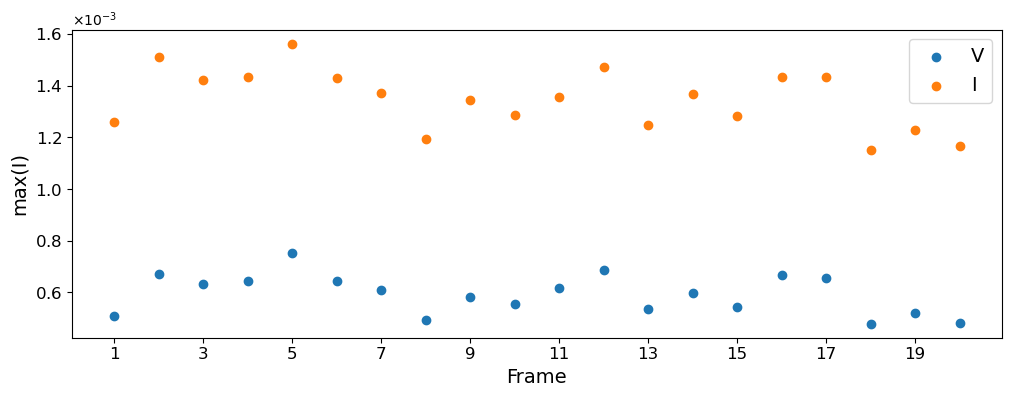

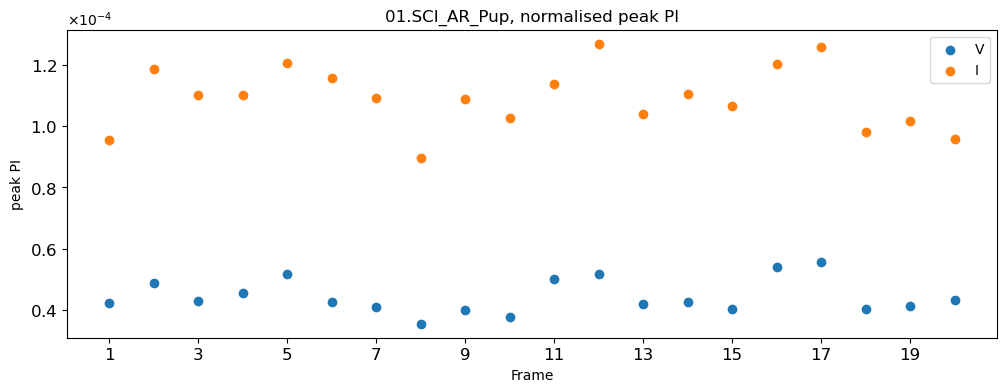

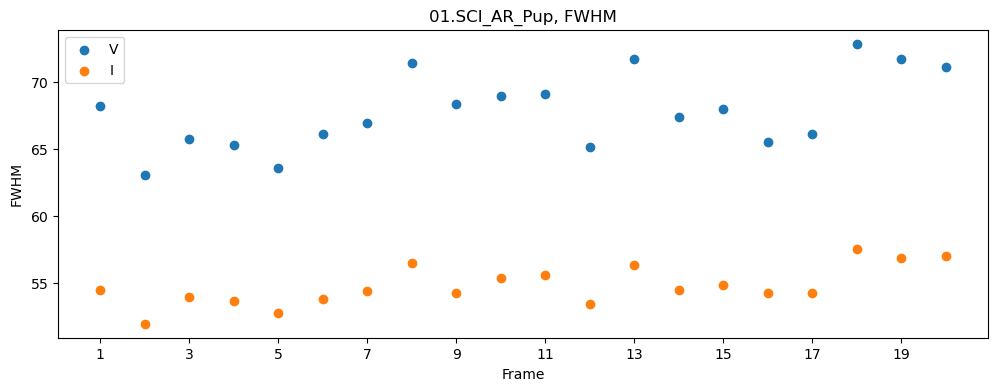

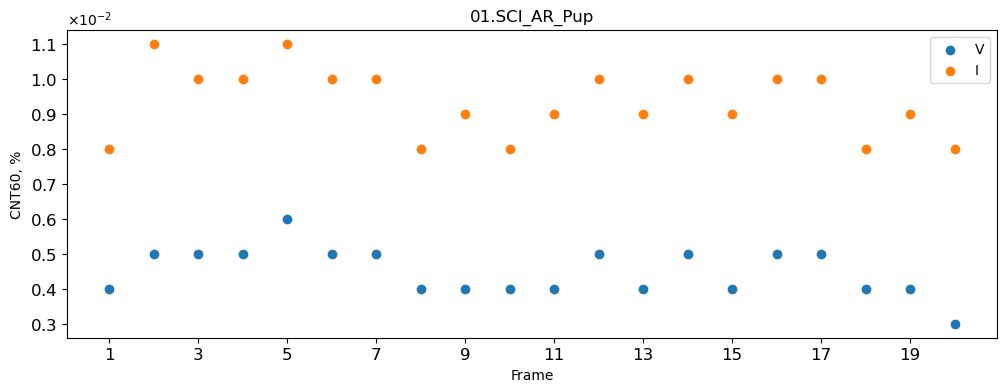

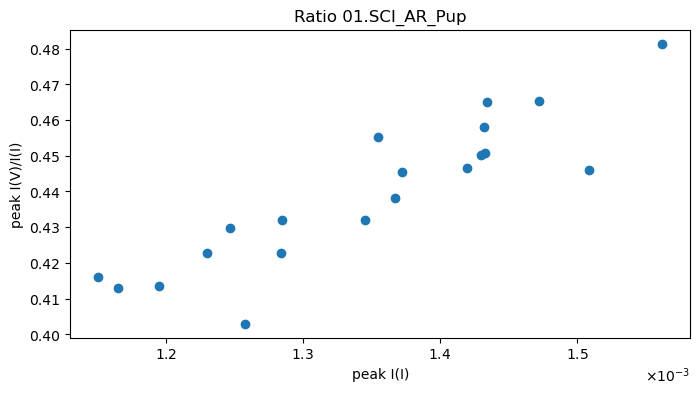

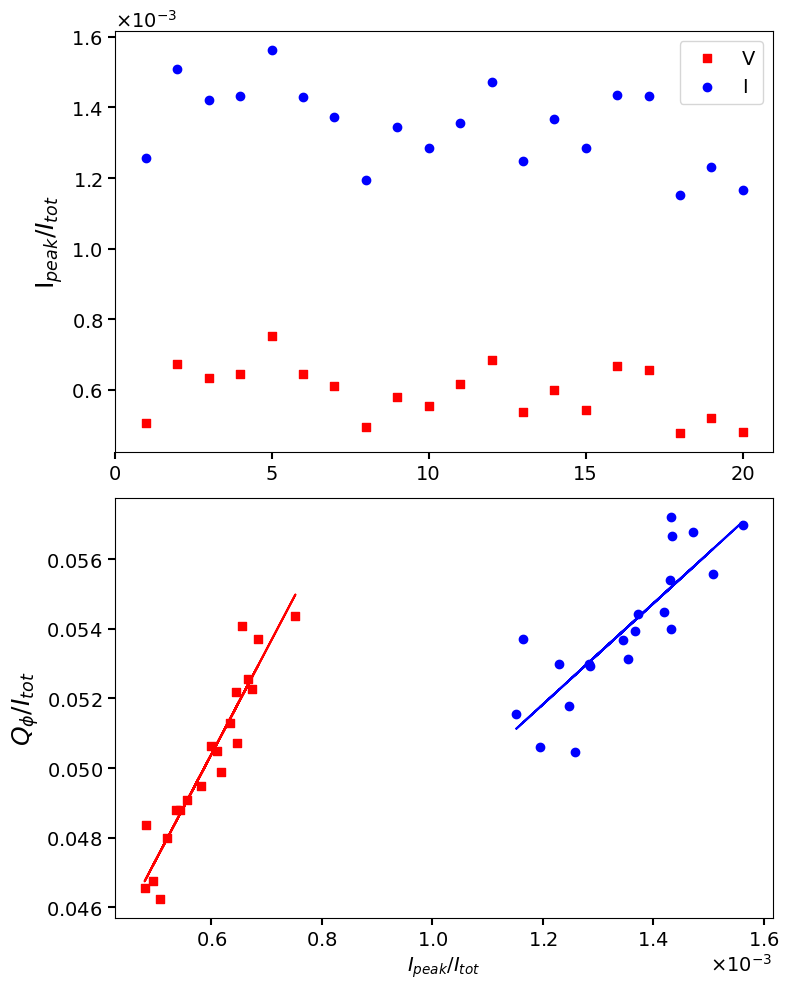

In [8]:
for star in stars:
    if star=='AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_reduction_data/individual_cycles/'+star+'/'
        input_filename =dirdat+'process_list.csv'
  
  
    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    
    specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'   #dirdat+'quality/'
    
    try:
    # Create target Directory
       os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    output_filename = figfolder0+star+'_0-3_V_AP_per_cycle.txt'
    df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_0-3_I_AP_per_cycle.txt'
    df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)
 
    print(df_orig_v.head())
    
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['Peak_i(Strehl)'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['Peak_i(Strehl)'],label='I')
    plt.ylabel('max(I)', fontsize=14)
    plt.xlabel("Frame", fontsize=14)  
    #plt.title(star+', normalised peak I')
    plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2),fontsize=12)
    plt.yticks(fontsize=12)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(fontsize=14)
    plt.savefig(specific_folder +star+'_peakI.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
   
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['Peak_PI'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['Peak_PI'],label='I')
    plt.ylabel('peak PI')
    plt.xlabel("Frame")  
    plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2),fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(star+', normalised peak PI')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.savefig(specific_folder +star+'_peakPI.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['FWHM'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['FWHM'],label='I')
    plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2))
    plt.ylabel('FWHM')
    plt.xlabel("Frame")  
    plt.title(star+', FWHM')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.savefig(specific_folder +star+'_fwhm.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['CNT60[%]'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['CNT60[%]'],label='I')
    plt.ylabel('CNT60, %')
    plt.xlabel("Frame")  
    plt.yticks(fontsize=12)
    plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2), fontsize=12)
    plt.title(star)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.savefig(specific_folder +star+'_cnt60.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    
    plt.figure(figsize=(8, 4))
    ratio={}
    ratio = df_orig_v['Peak_i(Strehl)']/df_orig_i['Peak_i(Strehl)']
    plt.scatter(df_orig_i['Peak_i(Strehl)'],ratio)
    plt.ylabel('peak I(V)/I(I)')
    plt.xlabel("peak I(I)")
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.title('Ratio '+star)
    plt.savefig(specific_folder +star+'_peakRatio.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
   
   
    
    #for paper
    plt.figure(figsize=(8, 10))
    
    # Subplot 1: Peak I
    plt.subplot(2, 1, 1)
    plt.scatter(df_orig_v['cycle'], df_orig_v['Peak_i(Strehl)'],marker='s', label='V',color='red')
    plt.scatter(df_orig_i['cycle'], df_orig_i['Peak_i(Strehl)'], label='I',color='blue')
    plt.ylabel('I$_{peak}/I_{tot}$', fontsize=18)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.offsetText.set_fontsize(14)
    plt.xticks(ticks=range(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1, 5), fontsize=14)
    plt.tick_params(axis='both', labelbottom=True,length=5,width=1.5,labelsize=14)  # Remove labeled ticks on the x-axis
    plt.legend(fontsize=14)

    # Subplot 2: Qphi
    plt.subplot(2, 1, 2)
    plt.scatter(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100,marker='s',color='red')
    slope, intercept = np.polyfit(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100, deg=1)
    plt.plot(df_orig_v['Peak_i(Strehl)'],slope*df_orig_v['Peak_i(Strehl)']+intercept,color='red')
    plt.scatter(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100,color='blue')
    slope, intercept = np.polyfit(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100, deg=1)
    plt.plot(df_orig_i['Peak_i(Strehl)'],slope*df_orig_i['Peak_i(Strehl)']+intercept,color='blue')
    plt.ylabel('$Q_{\phi}/I_{tot}$', fontsize=18)
    plt.xlabel("$I_{peak}/I_{tot}$", fontsize=14)  
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.offsetText.set_fontsize(14)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().xaxis.offsetText.set_fontsize(14)
    #plt.xticks(ticks=range(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1, 5), fontsize=14)
    plt.tick_params(axis='both',length=5,width=1.5,labelsize=14) 
   
    # Adjust x-axis limits to include the last tick
    #plt.xlim(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1)
    plt.tight_layout()
    plt.savefig(specific_folder + star + '_for_paper.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

## Variation of apperture polarimetry among frames
HERE IS NOT THE FINAL VERSION THAT WENT TO THE PAPER. FOR THE PAPER IN "Paper2_IRAS08_with_ref_correction.ipynb" FOR THE SELECTED FRAMES

In [25]:
star

'R'

Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Quality_indiv_cycles/variation_in_frames/  already exists
['reference' 'cycle' 'max_DoLP[%]' 'max_Q_phi' 'max_PI' 'sumQ/I[%]'
 'sumQ_phi/I[%]' 'sumPI/I[%]' 'FWHM' 'CNT60[%]' 'Peak_i(Strehl)' 'Peak_PI'
 'peak_Q_Phi' '0-3_PSF' '0-3_Q' '0-3_U' '0-3_Q/I[%]' '0-3_U/I[%]'
 '0-5_PSF' '0-5_Q' '0-5_U' '0-5_Q/I[%]' '0-5_U/I[%]' '0-10_PSF' '0-10_Q'
 '0-10_U' '0-10_Q/I[%]' '0-10_U/I[%]' '0-50_PSF' '0-50_Q' '0-50_U'
 '0-50_Q/I[%]' '0-50_U/I[%]' '0-100_PSF' '0-100_Q' '0-100_U'
 '0-100_Q/I[%]' '0-100_U/I[%]' '1-3_PSF' '1-3_Q' '1-3_U' '1-3_Q/I[%]'
 '1-3_U/I[%]' '3-5_PSF' '3-5_Q' '3-5_U' '3-5_Q/I[%]' '3-5_U/I[%]'
 '3-30_PSF' '3-30_Q' '3-30_U' '3-30_Q/I[%]' '3-30_U/I[%]' '5-30_PSF'
 '5-30_Q' '5-30_U' '5-30_Q/I[%]' '5-30_U/I[%]']


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/2477337457.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/2477337457.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/2477337457.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/2477337457.py:45: FutureWarning: The 'delim_whitespace' keyword

<Figure size 1200x400 with 0 Axes>

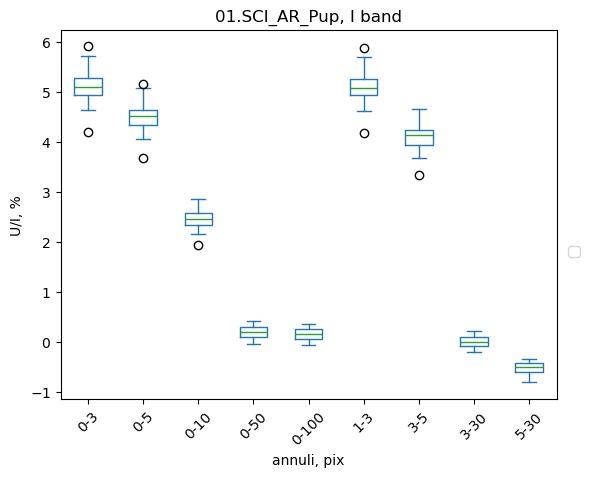

/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/2477337457.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))


<Figure size 1200x400 with 0 Axes>

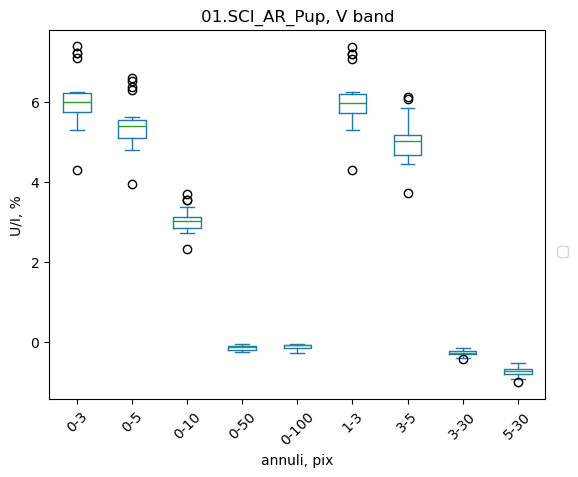

<Figure size 1200x400 with 0 Axes>

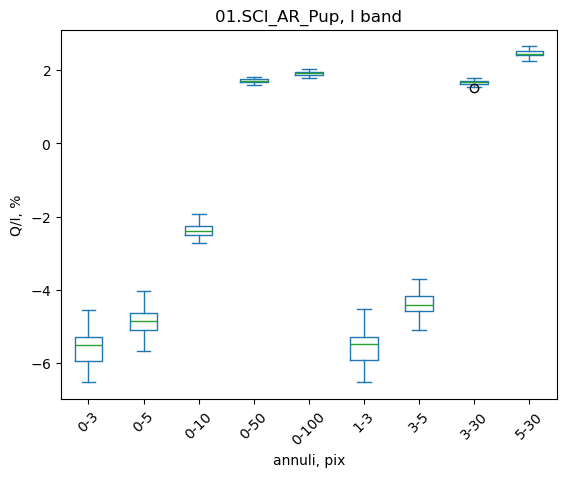

<Figure size 1200x400 with 0 Axes>

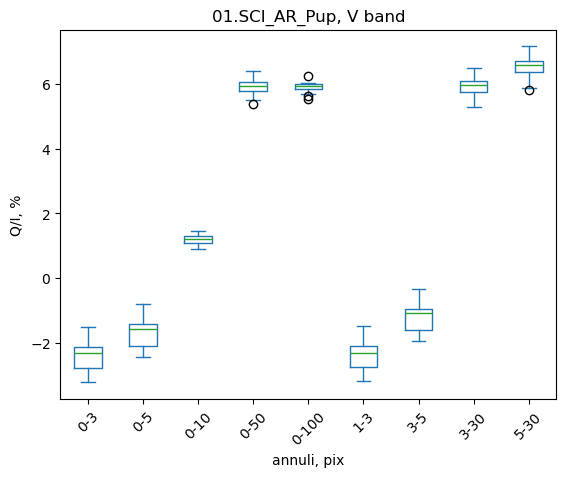

In [16]:
#plotting aperture photometry
for star in stars:
    if star=='AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+star+'/' 
        input_filename =dirdat+'process_list.csv'
        
    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    
    specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/variation_in_frames/'   #dirdat+'quality/'
    #specific_folder=dirdat+'quality/'
    try:
    # Create target Directory
       os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    output_filename = figfolder0+star+'_0-3_V_AP_per_cycle.txt'
    df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_0-3_I_AP_per_cycle.txt'
    df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)
 
    print(df_orig_v.columns.values)
    
    cycle_numbers = df_orig_v['cycle']
    current_labels = ['0-3', '0-5', '0-10', '0-50', '0-100', '1-3', '3-5', '3-30', '5-30']
    current_columnU = ['0-3_U/I[%]', '0-5_U/I[%]', '0-10_U/I[%]', '0-50_U/I[%]', '0-100_U/I[%]', '1-3_U/I[%]', '3-5_U/I[%]', '3-30_U/I[%]', '5-30_U/I[%]']
    current_columnQ = ['0-3_Q/I[%]', '0-5_Q/I[%]', '0-10_Q/I[%]', '0-50_Q/I[%]', '0-100_Q/I[%]', '1-3_Q/I[%]', '3-5_Q/I[%]', '3-30_Q/I[%]', '5-30_Q/I[%]']
    
    plt.figure(figsize=(12, 4))
    df_orig_i[current_columnU].plot(kind='box')
    positions = range(1, len(current_columnU) + 1)
    plt.xticks(positions, current_labels)
    plt.ylabel('U/I, %') 
    plt.xlabel('annuli, pix')
    plt.title(star + ', I band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    ax = plt.subplot(111)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))
   
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_I_UI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    plt.figure(figsize=(12, 4))
    # Plot each current data with the corresponding label and cycle numbers in the legend
    df_orig_v[current_columnU].plot(kind='box')
    plt.xticks(positions, current_labels)
    plt.ylabel('U/I, %')
    plt.xlabel('annuli, pix')
    plt.title(star + ', V band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    ax = plt.subplot(111)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_V_UI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 4))
    # Plot each current data with the corresponding label and cycle numbers in the legend
    df_orig_i[current_columnQ].plot(kind='box')
    plt.xticks(positions, current_labels)
    plt.ylabel('Q/I, %')
    plt.xlabel('annuli, pix')
    plt.title(star + ', I band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_I_QI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 4))
    # Plot each current data with the corresponding label and cycle numbers in the legend
    df_orig_v[current_columnQ].plot(kind='box')
    plt.xticks(positions, current_labels)
    plt.xlabel('annuli, pix')
    plt.ylabel('Q/I, %')
    plt.title(star + ', V band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_V_QI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
      

## Quality values for the data

In [10]:

for star in stars:
    

    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    
    specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    # Create target Directory
    try:
        os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    #output_filename = dirdat+star+'_0-3_V_AP_per_cycle.txt'
    #df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    #output_filename = dirdat+star+'_0-3_I_AP_per_cycle.txt'
    #df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)
 
    #print(df_orig_v.head())
    print(star)
    print('V')
    print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['Peak_i(Strehl)']*100),np.std(df_orig_v['Peak_i(Strehl)']*100)))
    print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['CNT60[%]']),np.std(df_orig_v['CNT60[%]'])))
    
    print('median peak PI normalised to total I %.6f percents +- %.6f'%(np.median(df_orig_v['Peak_PI']*100),np.std(df_orig_v['Peak_PI']*100)))
    
    print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_v['FWHM']),np.std(df_orig_v['FWHM'])))
    print('ratio of FWHM %.3f  '%(np.max(df_orig_v['FWHM'])/np.min(df_orig_v['FWHM'])))
    
    print('I')
    print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['Peak_i(Strehl)']*100),np.std(df_orig_i['Peak_i(Strehl)']*100)))
    print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['CNT60[%]']),np.std(df_orig_i['CNT60[%]'])))
    
    print('median peak PI normalised to total I %.6f percents +- %.6f'%(np.median(df_orig_i['Peak_PI']*100),np.std(df_orig_i['Peak_PI']*100)))
    
    print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_i['FWHM']),np.std(df_orig_i['FWHM'])))
    print('ratio of FWHM %.3f  '%(np.max(df_orig_i['FWHM'])/np.min(df_orig_i['FWHM'])))
    
    

Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Quality_indiv_cycles/  already exists
01.SCI_AR_Pup
V
median peak I normalised to total 0.060500 percents +- 0.007517
median CNT60 normalised to total 0.004500 percents +- 0.000671
median peak PI normalised to total I 0.004281 percents +- 0.000541
median FWHM 67.659 mas +- 2.769
ratio of FWHM 1.155  
I
median peak I normalised to total 0.136100 percents +- 0.011350
median CNT60 normalised to total 0.009500 percents +- 0.000963
median peak PI normalised to total I 0.010964 percents +- 0.000997
median FWHM 54.413 mas +- 1.431
ratio of FWHM 1.107  


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/2044130915.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/2044130915.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)


In [11]:
#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']
#stars=['HR4049_20190108','HR4049_20190107','HD71253','HD94680','HD96314','HD98025','V709_Car','HR4226','UMon_Katya']
stars=['02.SCI_AR_Pup']

for star in stars:

    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    
    specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    # Create target Directory
    try:
        os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    #print(df_orig_v.columns)
    print(df_orig_v.FWHM)
    

Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Quality_indiv_cycles/  already exists
0     71.074
1     71.687
2     72.841
3     66.119
4     65.500
5     67.947
6     67.371
7     71.696
8     65.100
9     69.119
10    68.952
11    68.370
12    71.387
13    66.901
14    66.127
15    63.552
16    65.275
17    65.726
18    63.052
19    68.176
Name: FWHM, dtype: float64


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/2605581612.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_96030/2605581612.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)


## Number of counts per frame

In [15]:

for star in stars:
    #figfolder=dirdat+'original/'

    
    if starnames[star] =='AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
    elif starnames[star]=='AR_Pup_dc_notnorm':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/' + starnames[star] + '/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/'+starnames[star]+'/'
        input_filename =dirdat+'process_list.csv'
  
        
    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}


    #print(reference)
    print(star)
    for fittype in fittypes:
        #output_filename = dirdat+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
        print(band[int(fittype)-1])
        for process in processes:
            if star=='UMon':
                dirName=dirdat
                iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
            else:        
                dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

            n=q.shape[0]

            iq_sum=np.sum(iq)
            iu_sum=np.sum(iu)
            pi_sum=np.sum(pi)
            print('sum of IQ %.2e, IU %.2e, PI %.2e' % (iq_sum, iu_sum, pi_sum))



01.SCI_AR_Pup
V
sum of IQ 3.08e+06, IU 3.05e+06, PI 8.03e+05
sum of IQ 3.09e+06, IU 3.07e+06, PI 8.25e+05
sum of IQ 3.09e+06, IU 3.07e+06, PI 7.80e+05
sum of IQ 3.10e+06, IU 3.09e+06, PI 8.75e+05
sum of IQ 3.11e+06, IU 3.09e+06, PI 8.22e+05
sum of IQ 3.11e+06, IU 3.07e+06, PI 8.33e+05
sum of IQ 3.13e+06, IU 3.11e+06, PI 8.03e+05
sum of IQ 3.13e+06, IU 3.11e+06, PI 8.19e+05
sum of IQ 3.11e+06, IU 3.12e+06, PI 9.49e+05
sum of IQ 3.00e+06, IU 3.13e+06, PI 1.00e+06
sum of IQ 2.99e+06, IU 3.02e+06, PI 9.88e+05
sum of IQ 3.19e+06, IU 2.99e+06, PI 1.29e+06
sum of IQ 3.10e+06, IU 3.07e+06, PI 8.08e+05
sum of IQ 3.07e+06, IU 3.11e+06, PI 8.26e+05
sum of IQ 3.06e+06, IU 3.08e+06, PI 8.55e+05
sum of IQ 3.15e+06, IU 3.12e+06, PI 8.40e+05
sum of IQ 3.11e+06, IU 3.12e+06, PI 8.79e+05
sum of IQ 3.11e+06, IU 3.12e+06, PI 8.79e+05
sum of IQ 3.10e+06, IU 3.13e+06, PI 9.07e+05
sum of IQ 3.08e+06, IU 3.04e+06, PI 8.53e+05
I
sum of IQ 2.98e+06, IU 2.98e+06, PI 8.91e+05
sum of IQ 3.00e+06, IU 3.01e+06, PI 8